<a href="https://colab.research.google.com/github/journalWheat/CSI4106-Project1/blob/main/CSI4106_Project1_JaredWagner_GeneralForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Title: Predicting the colour of a wine using Naive Bayes, Logistic Regression, and Multi-Layer Perceptron learning algorithms**

##**GROUP 97**
####Intellectual property of JARED WAGNER (Student \#300010832), Fall 2022.
####Submitted for CSI4106, Introduction to Artificial Intelligence. 
#####Project repository: https://github.com/journalWheat/CSI4106-Project1

#**Section 1: Introduction and goals**
-----
##An ode to wine
```
Hey come lets scatter flowers around,
and fill the chalice up with wine.
We'll crack the heavens' vault in half,
and hew a wholly new design. 
(Excerpt from 'Wine, Humans and Song,' translated from medieval Persian poet Hafez.)
``` 
([Source](http://poemsintranslation.blogspot.com/2015/07/hafiz-ghazal-367-human-wine-and-song.html?m=1)) + ([Info on Hafez](https://en.wikipedia.org/wiki/Hafez))

Wine, dear wine:

You have profoundly impacted the world. Though many people abstain from you, those who partake in consuming you become mind-bent by your company. Sommeliers might be the most mind-bent of us, specializing in combining their senses with their knowledge about wine's history to make appropriately fancy recommendations: what wine to pair with your salmon or your steak, what wine to bring to a house party, what wine to bring on a first date, and so on and so forth.

This is not a new phenomenon. The first evidence of grape wine production dates to 6100 years ago in an Armenian cave ([Source](https://www.decanter.com/wine-news/armenian-find-is-world-s-oldest-winery-42433/)). Dating back even further, anywhere from 9000 to 11000 years ago, there is evidence of a grape and rice wine being produced in China ([Source](https://www.sciencedirect.com/science/article/pii/S2212977418300619?via%3Dihub)). Perhaps humans' historied fixation upon wine is why in March 2020, a disputed story went viral across social media that claimed a group of elephants had broken into a village in China, "drinking 30kg of corn wine [before] they fell asleep in a nearby tea garden." ([Source](https://www.wusa9.com/article/news/verify/verify-did-elephants-get-drunk-on-corn-wine-while-humans-were-social-distancing/507-0c48ef63-33ec-478f-be6a-4ebdeb4b0299#:~:text=The%20tweet%20claimed%20the%20elephants,every%20instance%20of%20this%20post.))

Sommeliers with the most sensitive olfactory senses go on to write wine manuals (or so the story goes). These textbooks outline the expected characteristics of a peppery Australian Shiraz vs. a fruitful French Pinot Noir; of a vintage from 1980 vs. the same wine produced just last year. Many of these manuals even compare wines from different regions within a country, or sub-regions within a province, state, or territory. If your Chianti didn't come from the Chianti region of Tuscany, Italy, you may be entitled to compensation as part of a class action lawsuit. 

That was a joke, but it has a grain of truth. Many jurisdictions, including Italy, France, and even Ontario, have strict regulations for wine manufacture and labelling. In-order, these are called the DOP, AOC, and VQA standards. This is to be expected, given that the wine industry is a highly profitable sector: in 2019, the Canadian wine industry alone was valued at $11.57 billion dollars. ([source](https://www.winegrowerscanada.ca/our-industry/economic-impact/))

-----
##Data and goals
The dataset used in this analysis contains samples of various Viho Verde style wines from Portugal (the famous origin of "port" style wines), first published in 2009. The data was taken from Kaggle, where it had been shared from the UCI Machine Learning Repository.

This dataset is purportedly intended for models that would rank the wines, since there is an attached 'quality' metric for each sample. However, after seeing that each wine was also categorized by 'type' ('red'/'white'), this brought to mind an infamous study from 2001 ([source](http://www.daysyn.com/Morrot.pdf)) where 54 students training to become sommeliers were fooled by experimentors who had dyed white wine red. 

From the researchers' mischief, the students described the "red white wine" as they would a red wine, even though they had previously described the same white wine entirely differently when they had known it was a white wine with stereotypical character of a white wine. Few of the students consistently described the wine before and after it had been dyed, leading the researchers to suggest that the visual appearance of wine had a large affect on the participants' other senses. (Various news agencies were less charitable. In 2014, Gizmodo published an article "Wine tasting is bullshit. Here's why." ([Source](https://gizmodo.com/wine-tasting-is-bullshit-heres-why-496098276)) which cited the study to prove that "expert wine critics can't distinguish between red and white wines").

###The spurring of a question
Although the primary goal of this report's analysis is to compare the relative strengths of pitfalls associated with Naive Bayes, Logistic, and Multi-Layer Perceptron models, this story with the sommeliers leads to my personal tongue-in-cheek question: "can a computer guess whether a wine is red or white better than a a sommelier?" 

To answer this question, I will train three classification models using the aforementioned algorithms to determine whether a wine is 'white' or 'red' from the given features in the data set. Because there are only two classes, this is a binary classification problem. From these models, I will:
- Compare and contrast the effectiveness of each model for this task.
- Explore these models with a hands-on approach.
- Compare the sommeliers' performance to "a computer's" performance, i.e. my models.

###Applications
The question "can a computer guess whether a wine is red or white better than a sommelier," although humorous, has a real-world value. On its face it has entertainment value (otherwise no articles would be written about it), but looking closer it also conjours up questions about wine curation as a profession. If a computer can be a "virtual sommelier," then one can think of all kinds of applications for that. Exploring one example, imagine filling out a questionnaire from an app on your phone about your wine preferences, and then zap! Your phone returns a list of 10 wines it thinks that you will enjoy. No hiring a specialist, no wasting time, you know exactly what you want after 2 minutes with the app. 

Of course the results of this experiment do not *directly* fit into that example, but the models designed here could be components of that application. For example, if these models characterize a white wine as a red, then this could be a clue that this "white" wine has a red-like flavor profile that will not be appreciated as much by a person who does not like red wine.

#**Section 2: Analyzing the dataset**
-----
##Analyzing the dataset

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Missing values table
type                     0
fixed acidi

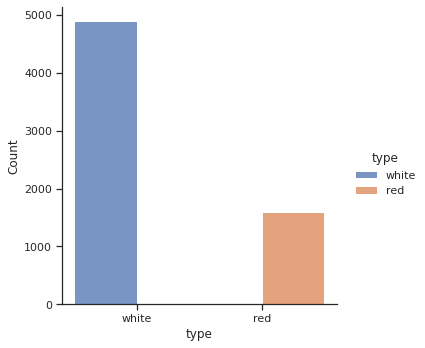

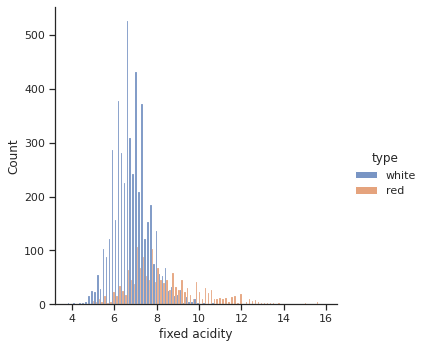

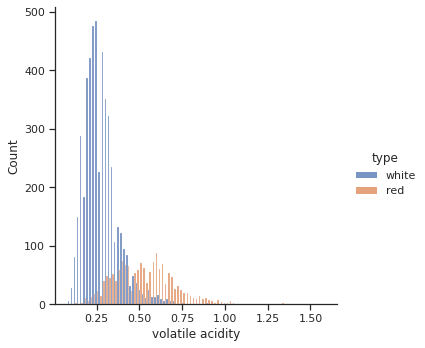

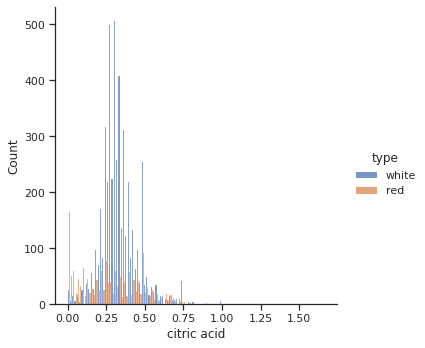

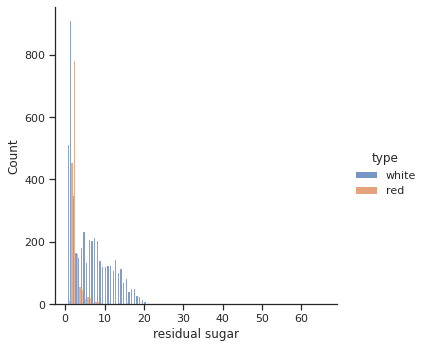

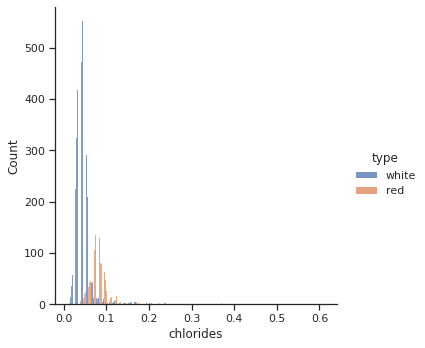

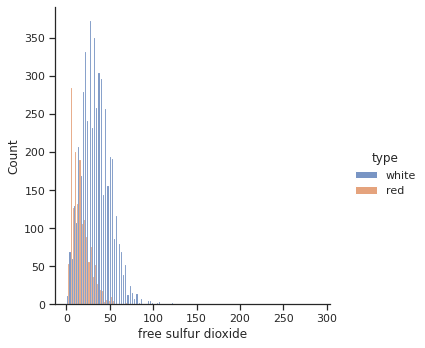

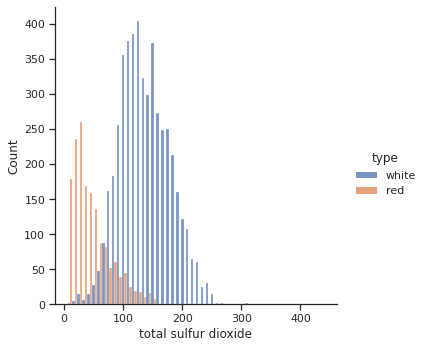

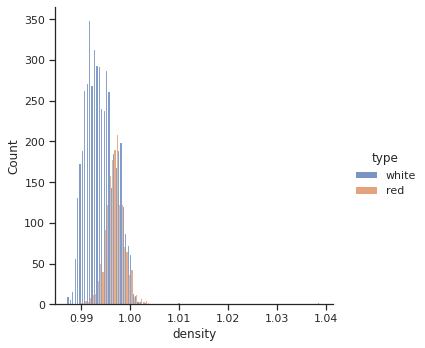

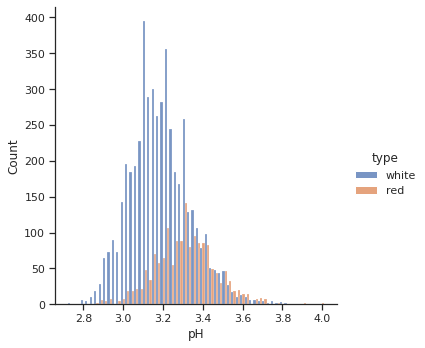

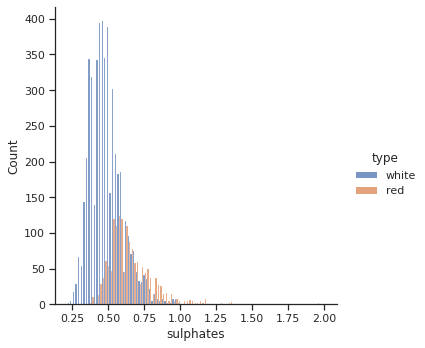

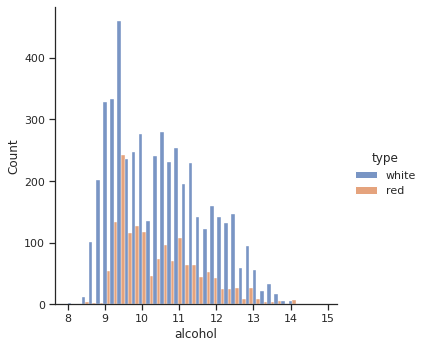

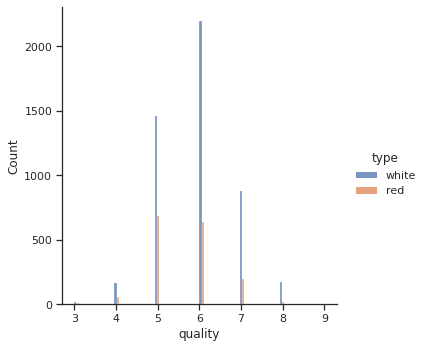

In [30]:
# data from: https://www.kaggle.com/datasets/rajyellow46/wine-quality
# seaborn docs: https://seaborn.pydata.org/tutorial/distributions.html
# imports for data processing
import pandas as pd
import numpy as np

# imports and settings for nice graphs
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.notebook_repr_html', True)
sns.set_palette(palette='deep')
sns.set_style(style='ticks')

# df info: location, target column
df_location = 'https://raw.githubusercontent.com/journalWheat/CSI4106-Project1/main/winequalityN.csv' 
sample_location = 'https://raw.githubusercontent.com/journalWheat/CSI4106-Project1/main/sample.csv'
target = 'type'

# read data
raw_df = pd.read_csv(df_location)
#raw_df = pd.read_csv(df_location).dropna().sample(n=len(pd.read_csv(df_location).dropna()),random_state=1)

# print some useful statistics
display(raw_df.head(5))
print("\n") ############################## line break
raw_df.info(verbose=True, show_counts=True)
print("\n") ############################## line break
print("Missing values table")
print(raw_df.isna().sum())
print("TOTAL null=",raw_df.isna().sum().sum())
print("\n") ############################## line break
#med_sample_df = raw_df[100:601].copy() # sample of 500
#small_sample_df = raw_df[:100].copy() # sample of 100

# Compare the distributions of each feature
# for column in raw_df.drop(columns='target', axis=1):
for column in raw_df:
  sns.displot(raw_df, x=column, hue=target, multiple='dodge')

##Initial observations
That's a lot of data! These are the key highlights about this dataset:
1. The samples are not shuffled in the dataframe.
2. There are 6497 samples, and 38 missing values.
3. There are 13 columns. Excluding the target variable 'type', that means that there are 12 potential predictors.
4. The target value is biased towards 'white' by a ratio of ~1:4.
5. The data is not uniformly distributed. No action is required on this point, but if all features were uniformly distributed (either by a true random distribution or by a then that would potentially indicate that the data is fake; an unfortunate consideration for Kaggle-sourced data.

##Initial discussion (sorted by points in 'Initial observations')
1. The dataframe needs to be shuffled so that data folds taken with KFold in Section 5 are also shuffled. This can be achieved using KFold itself, but there is more analysis to do in this section which also required a shuffled dataframe (specifically whether the data is separable). Therefore, the data will be read again and shuffled using a seed. Shuffling using a seed ensures that an astute reader with access to the dataset could repeat the experiments herein, since shuffling with the same seed will result in an identically shuffled dataset.
2. 6497 samples is a reasonable amount of data for the purposes of this report. Since the number of missing values is low, just 38, they will simply be discared; it is unlikely that such a small sample will have much impact on the models given the relatively high number of samples.
3. 12 predictors might be high or might be low, but that cannot be determined from the data above. Feature selection is discussed in Section 3, where graphical "common sense" and methodical solutions are compared for the data.
4. This is an "orange flag." It could impact model training, but not necessarily depending on the features selected.
5. Lucky! Well, this data is from a real publication, so that is expected. There are a lot of fake datasets on Kaggle. This is discussed under 'Disclosure' at the end of the notebook, as this is the third dataset under consideration (the other two looked "too good to be true," i.e. likely computer generated data.)

One last thing need to be determined: is the data learnable? One "common sense" solution is to create a scatterplot matrix. If there are a number of scatterplots where the data "looks like" it could be separated by a line, that is a promising rule of thumb that the data is learnable.

##Transformations
Before proceeding, some transformations are made on the raw data. Specifically:
- The data is shuffled.
- Null values are dropped.


In [31]:
# re-reading the data from CSV such that it is (reproducibly) randomized
seed = 1
raw_df = pd.read_csv(df_location).dropna().sample(n=len(pd.read_csv(df_location).dropna()),random_state=seed)
med_sample_df = raw_df[43:643].copy() # sample of 600
small_sample_df = raw_df[43:143].copy() # sample of 100

# display the data to demonstrate it is shuffled ... no matter how many times this cell is ran, the order of the data will be the same since it is shuffled from a seed
display(raw_df.head(5))

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3746,white,7.4,0.27,0.28,1.8,0.040,45.0,121.0,0.99043,3.02,0.40,11.9,5
425,white,7.0,0.21,0.28,8.7,0.045,37.0,222.0,0.99540,3.25,0.54,10.4,6
3967,white,6.3,0.27,0.51,7.6,0.049,35.0,200.0,0.99548,3.16,0.54,9.4,4
6098,red,7.7,0.57,0.21,1.5,0.069,4.0,9.0,0.99458,3.16,0.54,9.8,6
3184,white,6.2,0.10,0.41,1.0,0.040,17.0,76.0,0.98988,3.14,0.56,11.4,7


##Final analysis
Finally, a small subset of 100 samples is plotted with a scatterplot matrix.

From the matrix, there are several plots which seems to be separable with a line (the best example of this is any of the plots for 'total sulfur dioxide'), meaning that the target class is likely learnable. This scatterplot will be referred back to in the next section where feature selection is discussed.

In [32]:
#sns.pairplot(data=small_sample_df, hue=target)

#**Section 3: Feature selection**
-----
##Using domain knowledge for feature selection
One possible approach to feature selection involves making inferences from known data, either to highlight useful features or to remove useless features. To actually make this selection means relying on (in order): prior research on the topic, common knowledge, and personal experience.

Searching for research on the chemical composition of red vs. white wine was inconclusive, but a variety of lifestyle-oriented publications have written on the relative characteristics of red and white wine.

Summarizing these writings:
- White wines are commonly described as dry, crisp, and fruity, whereas red wines are described as rich and bitter.
- The process for fermenting each type of wine is different. White wines are produced from skinless grapes, whereas red wines are produced from the whole grape. This is why darker wines are more bitter: they contain tannin, a bitter-tasting chemical located in the skin of the grape.
- There are exceptions to the general flavor profile of a white vs. red wine, where a white might taste like a red and vice-versa.
- White wine's "crisp" profile is suggested to be the result of either residual sugar, acidity, or alcohol content.
- Alcohol content actually seems to be lower, on average, for white wines.

From my personal experience fermenting apple cider, dryness seems to be a byproduct of low residual sugar specifically. For example, a cider like Strongbow 'Original Dry' has just 2.6g sugar/100mL ([source](https://www.strongbow.com/ca/en/apple-ciders/original-dry)), and this is a cider I would compare to many of the "dry-er" ciders I have fermented myself.

###Reading tea leaves (selecting features from the scatterplot)
Combing the domain knowledge above with the scatterplot matrix, there are some useful insights:
- 'total sulfur dioxide' is an easy pick from the scattplot, since it is the most clearly differentiated features for the target.
  - 'free sulfur dioxide' is a clearly related feature to this one, but these probably should not be chosen together because they are not independent variables, and algorithms such as Naive Bayes work under the assumption that features are independent.
- 'residual sugar', a feature discussed above, is also interesting because almost 'red' samples are located in a small neighborhood on the range.
- 'chlorides' shows some clear differentiability, but was not a feature considered in domain knowledge because it did not come up in initial research. Chlorides and their impact on wine flavor seem to have been thoroughly studied, since high concentrations of chloride are considered to give an undesirable salty taste to wine. High concentrations of chloride are associated with red grape varietals,([source](https://www.scielo.br/j/cta/a/HQsrPrPMNZYgRzSKtrjHyHh/?format=pdf&lang=en)) particularly if the graps were grown near a coast ([source](https://mantech-inc.com/wp-content/uploads/2014/07/105-Chloride-in-Wine-by-Titration.pdf)); Portugal is coastal, so one explanation for the split in the data could be that white and red grape varietals are grown in separate vineyards, some near the coast and some further away.

Only one feature stands out as outright useless, and that is 'quality'. The distribution of the wines makes it look like either are around equally likely for any particular ranking.

Summarizing: the important features that seem evident from domain knowledge and graphical analysis are: {'total sulfur dioxide','residual sugar','chlorides'}, and 'quality' does not seem useful at all.

##Analytical approaches to feature selection
One drawback to using domain knowledge to choose important features is that it is a haphazard process prone to errors. An alternative is to use tangible metrics to score the importance of a variable, selecting the most important variables for model building.
###Mutual information scores
One of these approaches is by using MI (Mutual Information) scores. What these scores measure is the dependency between variables. The higher the score, the more closely dependent a feature is with the target variable.

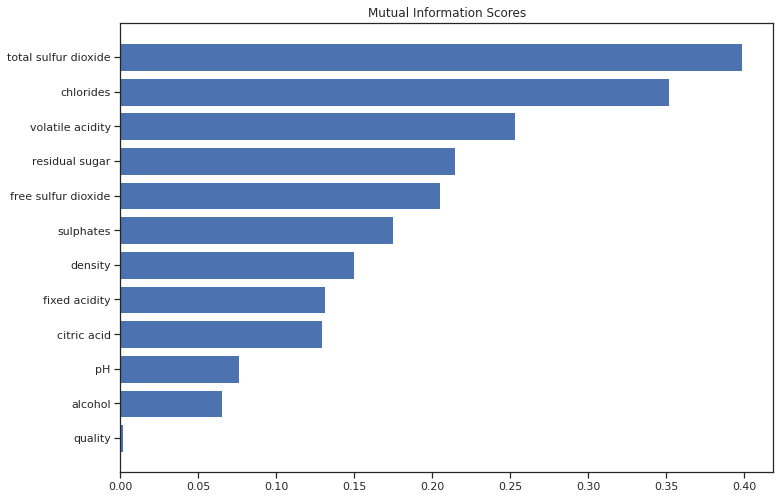

In [33]:
# code has been modified from: https://www.kaggle.com/code/ryanholbrook/mutual-information
# reference on sklearn.feature_selection.mutual_info_classif: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif

# imports
from sklearn.feature_selection import mutual_info_classif

# prepare data ... here, we simply use 600 random samples to test the MI score
X = med_sample_df.copy()
y = X.pop(target)

# code for generating MI scores
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores[::3]  # show a few features with their MI scores

####Display
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores)

##Putting it all together

Three of four features identified above are in the top four MI scores. One feature which I did not identify was volatile acid. Since this corresponds with my prior analysis, I will take the top four features in the MI chart as features for training the models.

In [34]:
model_features = {'total sulfur dioxide', 'chlorides', 'volatile acidity', 'residual sugar'}

#Section 4: Encoding features
-----
##What is encoding?
Encoding is a technique where data is transformed so that it can be fed into an algorithm. Since some algorithms take only specific types of data, encoding is a vital part of pre-processing.

##Encoding for Naive Bayes
There's a big, big problem with my features: they are all continous! Naive Bayes can only take discrete data, since continuous probabilities at a point X = x are equal to zero (this is a byproduct of having an infinite number of possible values in a continuous range of values). To tackle this problem, the following action will be taken:
1. Put the data into n equally distributed buckets corresponding to the % of samples in that range. For example, for n=3, values in the first 33% of samples are placed in bucket 1, the next 33% are placed in bucket 2, and the remaining samples are placed in bucket 3.
2. Using one-hot-encoding, transform the row into n mutually-exclusive rows with values of either 1 or 0.

I should note that point #1 has some hidden assumptions with potential consequences. By splitting the data evenly into n buckets, I am assuming that the target classes are distributed differently enough across those buckets for the condional probabilities to differentiate which target class is most likely within that range.

This is a bold assumption. What if, by chance, the data is distributed such that the most dominant target value (red) is most likely across all of the buckets for every feature? Then, the algorithm will be useless because it will always guess that the wine is red.

On the other hand: using too many buckets for the data is also a problem. Consider that keeping the data continuous is like having an infinite number of buckets, in which case the conditional probability of any particular point is equal.

In [35]:
 # qcut: https://stackoverflow.com/questions/53963183/how-to-use-kbinsdiscretizer-to-make-continuous-data-into-bins-in-sklearn
 # get_dummies: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

def one_hot_encode(raw, target, features, n_buckets):
  # get a dataframe with the features we care about
  df = raw[features].copy()

  # use Pandas to replace the values in each dataframe with the quantile they belong to
  for column in df:
    df[column] = pd.qcut(df[column], q=(n_buckets+1), labels=False)

  # expand each column out into mutually exclusive columns
  for column in df:
    onehot_columns = pd.get_dummies(df[column], prefix=column+' ',prefix_sep='', drop_first=True)
    df = pd.concat([df, onehot_columns],axis=1)
    df = df.drop(column, axis=1)

  # add the target back at the end of the dataframe ... everything have been done inplace, so this is okay
  df = pd.concat([raw_df[target],df],axis=1)
  #df[target] = raw[target].copy()

  return df

one_hot_encoded_wine_df = one_hot_encode(raw_df, target, model_features, 4)
display(one_hot_encoded_wine_df.head(2)) # sneak peak to see the data looks as expected

,type,residual sugar 1,residual sugar 2,residual sugar 3,residual sugar 4,chlorides 1,chlorides 2,chlorides 3,chlorides 4,volatile acidity 1,volatile acidity 2,volatile acidity 3,volatile acidity 4,total sulfur dioxide 1,total sulfur dioxide 2,total sulfur dioxide 3,total sulfur dioxide 4
3746,white,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
425,white,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


##Encoding for Logistic Regression and Multi-Layer Perceptron
Both algorithms, Logistic Regression and Multi-Layer perceptron, can take discrete or continuous variables. Given this, there are two options:
1. Pass the original data to either model as training data.
2. Encode the data the same way as with Naive Bayes.

Since this analysis hinges upon giving the same data to all three algorithms, the same encoding strategy will be used as with Naive Bayes shown above.

# Section 5: Making cuts for k-fold cross validation
-----
##Theory
K-fold cross validation is a method used to prevent overfitting. Overfitting occurs when a model performs well on training data, but fails to perform on real data. Through this process, data is split into k groups. Then, the model is trained k times (using a different data fold k for testing). By evaluating the performance of the model on all k runs, one obtains a better understanding on the general health of the model compared to if the model had been trained and tested only once.

##Considerations for the the wine dataset

"Randomness" is a subject worth exploring before I split the data using k-fold cross validation. For some datasets where samples are dependent, randomizing the data would be innapopriate (for example, some data sets where samples are dependent on time). However, the samples in my data are independent, so I want to reflect that in each of the folds I take.

This observation might initially seem to contradict the code immediately below, where the data does not appear to be shuffled. This is because when the data was initially read from CSV, it was shuffled using a pseudorandom seed. This approach was chosen so that the work in this notebook would be reproducible. Because the data was shuffled from a seed, that means anybody can shuffle the CSV the same way as was done in this report.

##Choice of k
For this report, 10-fold cross validation was selected since it is commonly used in data science literature. Examining the impact of taking different folds could be an interesting follow-up analysis, but is outside of the scope of this report.

In [36]:
# Guide on KFold: https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/
# Some code in this section is from: https://www.youtube.com/watch?v=gJo0uNL-5Qw
from sklearn.model_selection import KFold

# prepare 10 splits
def set_k_fold(n=10):
  return KFold(n_splits=n, random_state=None, shuffle=False)

kf = set_k_fold(n=10)

# Section 6, 7, 8: training, testing (k-fold), and evaluating algorithms
-----
##Justification on combining these sections
Since these activities are highly interrelated, they are combined in this report. The following activities are explored for each algorithm:
- Training each model
- Testing/validating each model using k-fold cross-validation
- Evaluating each model using precision and recall measures

The end result is the same, but it is easier to combine these activities somewhat than to try to explicitly split them. For example, when each algorithm is train it is simpler to "cut to the chase" and train them using all 10 folds taken above. Similarly, it's easier to simply collect statistics on how well each algorithm performs on each data fold as they are being trained.

## Precision and recall functions
This subsection contains helper functions for collecting and displaying precision and recall data, as this is a task which is repeated for every model of every run. The main metrics we want to maximize are:
- Weighted recision: a measure of how trustworthy a "positive" reult is.
- Weighted recall: a measure of how well a model can identify a positive.
- F1-score: the harmonic mean of precision and recall.
- Balanced accuracy: an overall score of how accurate the algorithm is.

In [79]:
# takes a list of confusion matrixes, parses the data for TP, FP, TN, FN.
# With labels=['red','white'], Red is treated as (+) and White (-)
# Calculates precision, recall.
# Displays relevant evaluation metrics.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, balanced_accuracy_score, f1_score

# dictionary for storing the stats from each run
bayes_stats = {
    'Weighted Precision' : [],
    'Weighted Recall' : [],
    'Weighted F1 Score' : [],
    'Balanced Accuracy' : []
}

LR_stats = {
    'Weighted Precision' : [],
    'Weighted Recall' : [],
    'Weighted F1 Score' : [],
    'Balanced Accuracy' : []
}

MLP_stats = {
    'Weighted Precision' : [],
    'Weighted Recall' : [],
    'Weighted F1 Score' : [],
    'Balanced Accuracy' : []
}

def get_stats(Y_test, y_pred, labels, model_case):
  if (model_case=='bayes'):
    bayes_stats['Weighted Precision'].append(precision_score(Y_test, y_pred, average='weighted'))
    bayes_stats['Weighted Recall'].append(recall_score(Y_test, y_pred, average='weighted'))
    bayes_stats['Balanced Accuracy'].append(balanced_accuracy_score(Y_test, y_pred, ))
    bayes_stats['Weighted F1 Score'].append(f1_score(Y_test, y_pred, average='weighted'))
  elif (model_case=='logistic regression'):
    LR_stats['Weighted Precision'].append(precision_score(Y_test, y_pred, average='weighted'))
    LR_stats['Weighted Recall'].append(recall_score(Y_test, y_pred, average='weighted'))
    LR_stats['Balanced Accuracy'].append(balanced_accuracy_score(Y_test, y_pred, ))
    LR_stats['Weighted F1 Score'].append(f1_score(Y_test, y_pred, average='weighted'))
  elif (model_case=='multi layer preceptron'):
    MLP_stats['Weighted Precision'].append(precision_score(Y_test, y_pred, average='weighted'))
    MLP_stats['Weighted Recall'].append(recall_score(Y_test, y_pred, average='weighted'))
    MLP_stats['Balanced Accuracy'].append(balanced_accuracy_score(Y_test, y_pred, ))
    MLP_stats['Weighted F1 Score'].append(f1_score(Y_test, y_pred, average='weighted'))
  else:
    raise RuntimeError(model_case, "is an invalid value for model_case in get_stats(...)!")

def print_stats(run_num, model_case):
  # convert dictionary to a useable format for Seaborn
  if (model_case == 'bayes'):
    stats_df = pd.DataFrame.from_dict(bayes_stats)
  elif (model_case == 'logistic regression'):
    stats_df = pd.DataFrame.from_dict(LR_stats)
  elif (model_case == 'multi layer preceptron'):
    stats_df = pd.DataFrame.from_dict(MLP_stats)
  else:
    raise RuntimeError(model_case, "is an invalid value for model_case in print_stats(...)!")

  print("Printing summary statistics for ",run_num," of", model_case)
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.boxplot(data=stats_df)
  print('\n')
  display(stats_df)

##Run 1
###Naive Bayes

Testing stats
0.7857609832760993
0.7511591962905718
0.7402380429745616
0.7614671515094996
Testing stats
0.8065634493417897
0.7511591962905718
0.7466375569391661
0.7669529576331411
Testing stats
0.788085232255172
0.7387944358578052
0.7332760595647194
0.7528166498766955
Testing stats
0.7808985528115775
0.7306501547987616
0.7004067065073041
0.7471810680450177
Testing stats
0.7612879517131931
0.7043343653250774
0.6862952499835753
0.7219074183994253
Testing stats
0.7874056939210895
0.7507739938080495
0.7401260504201681
0.7616418808095858
Testing stats
0.766554686890236
0.6919504643962848
0.6726142827048662
0.7150069742137286
Testing stats
0.7599572958770924
0.6873065015479877
0.6894675925925926
0.7069229139584847
Testing stats
0.7793162019849069
0.7368421052631579
0.7281952042474539
0.7492075135574127
Testing stats
0.7827295301416288
0.7414860681114551
0.7338235294117648
0.7533982806590203
Printing summary statistics for  1  of bayes




,Weighted Precision,Weighted Recall,Weighted F1 Score,Balanced Accuracy
0,0.785761,0.751159,0.761467,0.740238
1,0.806563,0.751159,0.766953,0.746638
2,0.788085,0.738794,0.752817,0.733276
3,0.780899,0.730650,0.747181,0.700407
4,0.761288,0.704334,0.721907,0.686295
5,0.787406,0.750774,0.761642,0.740126
6,0.766555,0.691950,0.715007,0.672614
7,0.759957,0.687307,0.706923,0.689468
8,0.779316,0.736842,0.749208,0.728195
9,0.782730,0.741486,0.753398,0.733824


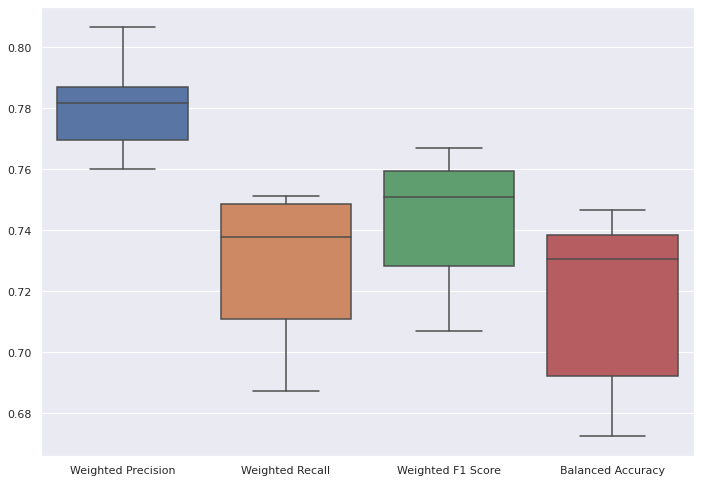

In [74]:
# implementation using sklearn.naive_bayes.CategoricalNB
# documentation: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# NB model
def naive_bayes(X_train, X_test, y_train, y_test, alpha, fit_prior, class_prior):
  ###################### MODEL
  clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior, class_prior=class_prior)
  clf.fit(X_train, y_train)

  ###################### DATA ABOUT PERFORMANCE
  y_pred = clf.predict(X_test)
  get_stats(y_test, y_pred, np.unique(y_pred), 'bayes')


#####APPLY K-FOLD############################################################################################################
# Some code taken from: https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
# (specifically to assign X_train, X_test, y_train, y_test appropriately)

# Trains k naive bayes models, using k-fold validation. Prints stats summarizing the validation (e.g. precision of each run).
def naive_bayes_k_fold(df, alpha, fit_prior, class_prior):
  # clear bayes stats for this run kept in bayes_states
  for value in bayes_stats.values():
    del value[:]
  #####
  X = np.array(df.drop(columns=target, axis=1).values.tolist())
  y = np.array(df[target].values.tolist())

  # code for running the K-fold split
  for train_index, test_index in kf.split(df):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    naive_bayes(X_train, X_test, y_train, y_test, alpha, fit_prior, class_prior)

####RUN 1 BELOW#################################################################################
#parameters (changed in each run)
alpha=1.0
fit_prior=False
class_prior=None

# training, testing validating the data
naive_bayes_k_fold(one_hot_encoded_wine_df, alpha, fit_prior, class_prior)
print_stats(run_num=1, model_case='bayes')

#below, there are stats on this run

###Logistic Regression

Printing summary statistics for  1  of logistic regression




,Weighted Precision,Weighted Recall,Weighted F1 Score,Balanced Accuracy
0,0.798645,0.808346,0.791996,0.694843
1,0.823458,0.834621,0.822226,0.709139
2,0.827286,0.834621,0.820952,0.719085
3,0.799829,0.817337,0.796716,0.657135
4,0.816955,0.826625,0.807881,0.687274
5,0.811284,0.818885,0.802615,0.703151
6,0.790989,0.808050,0.795086,0.665080
7,0.778053,0.795666,0.774777,0.654578
8,0.802869,0.812693,0.796369,0.695502
9,0.805235,0.812693,0.793027,0.687605


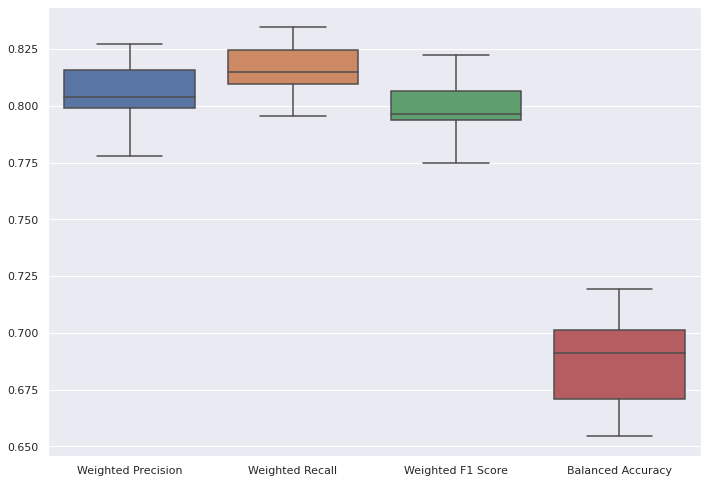

In [81]:
##Multi-Layer Perceptron
# imports
from sklearn.linear_model import LogisticRegression

## logistical progression model
def log_progress(X_train, X_test, y_train, y_test):
  ## instantiate and train the model
  clf = LogisticRegression(random_state=0)
  clf.fit(X_train, y_train)

  ## print some data about the model's performance
  y_pred = clf.predict(X_test)
  get_stats(y_test, y_pred, np.unique(y_pred), 'logistic regression')

#####APPLY K-FOLD############################################################################################################

# Trains k naive bayes models, using k-fold validation. Prints stats summarizing the validation (e.g. precision of each run).
def LR_k_fold(df):
  # clear any stats leftover from previous runs
  for value in LR_stats.values():
    del value[:]
  #####
  X = np.array(df.drop(columns=target, axis=1).values.tolist())
  y = np.array(df[target].values.tolist())

  # code for running the K-fold split
  for train_index, test_index in kf.split(df):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    log_progress(X_train, X_test, y_train, y_test)

####RUN 1 BELOW#########################################################################
#parameters (changed in each run)


# training, testing validating the data
LR_k_fold(one_hot_encoded_wine_df)
print_stats(run_num=1, model_case='logistic regression')
#below, there are stats on this run

#Section 8: Evaluating the "first run" of models with precision/recall measures
-----

#Section 9: Parameter modifications
-----
##Run 2
###Naive Bayes
One parameter which can be very important with Naive Bayes is the prior. In this iteration, fit_prior is set to True.

Printing summary statistics for  2  of bayes




,Weighted Precision,Weighted Recall,Weighted F1 Score,Balanced Accuracy
0,0.742907,0.765070,0.734982,0.619424
1,0.777232,0.799073,0.775791,0.636661
2,0.793005,0.803709,0.775760,0.649135
3,0.763769,0.792570,0.762687,0.606532
4,0.780836,0.798762,0.769292,0.631417
5,0.770106,0.784830,0.755880,0.638445
6,0.768453,0.794118,0.772564,0.622941
7,0.763422,0.784830,0.753497,0.620126
8,0.753226,0.773994,0.745767,0.627269
9,0.774602,0.786378,0.754138,0.633824


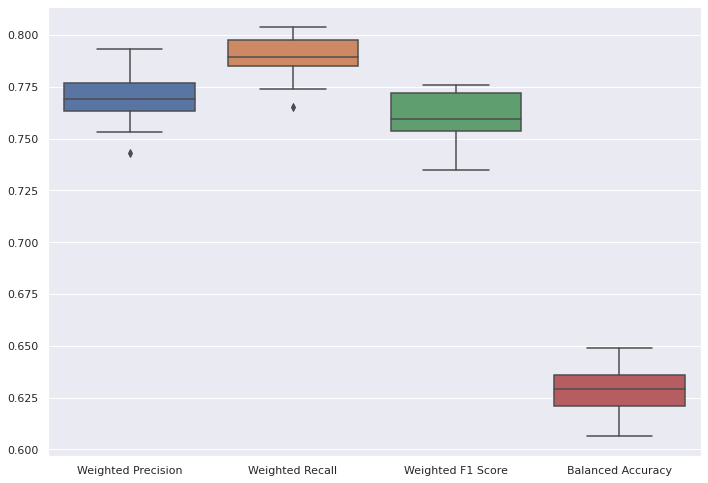

In [62]:
#RUN 2
#parameters (changed in each run)
alpha=1.0
fit_prior=True
class_prior=None

# training, testing validating the data
naive_bayes_k_fold(one_hot_encoded_wine_df, alpha, fit_prior, class_prior)
print_stats(run_num=2, model_case='bayes')

###Logisitic Regression


###Multi-Layer Perceptron

##Run 3
###Naive Bayes
The remaining parameters that can be adjusted are alpha (a smoothing parameter) and class_prior. In previous iterations, the class priors were not set for the algorithm. Since we know that the rough proportion of white:red is 4:5, priors are set accordingly for these classes.

Printing summary statistics for  3  of bayes




,Weighted Precision,Weighted Recall,Weighted F1 Score,Balanced Accuracy
0,0.755105,0.768161,0.722335,0.597674
1,0.770256,0.794436,0.757856,0.603077
2,0.784658,0.794436,0.757577,0.622394
3,0.756553,0.789474,0.748900,0.582254
4,0.764705,0.786378,0.744050,0.594573
5,0.757731,0.770898,0.724019,0.594958
6,0.758491,0.792570,0.751008,0.578499
7,0.765399,0.781734,0.734958,0.590818
8,0.771944,0.780186,0.737266,0.608537
9,0.788321,0.786378,0.742666,0.614916


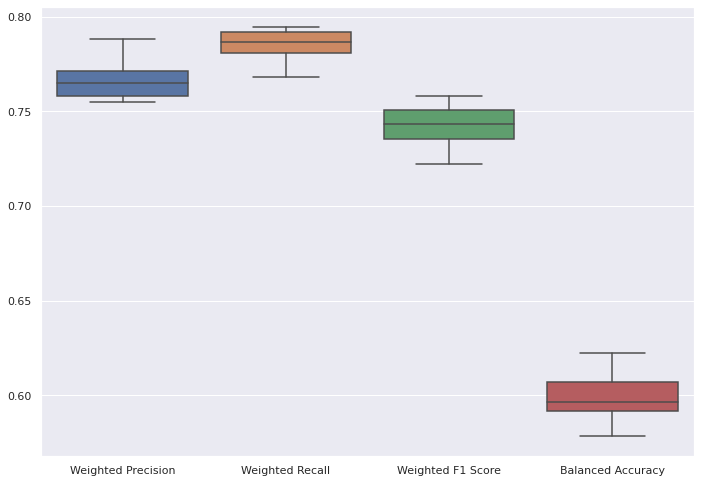

In [63]:
#RUN 3
#parameters (changed in each run)
alpha=1.0
fit_prior=False
class_prior=[0.2,0.8]

# training, testing validating the data
naive_bayes_k_fold(one_hot_encoded_wine_df, alpha, fit_prior, class_prior)
print_stats(run_num=3, model_case='bayes')

#**Section 10: Analyzing the results**
-----

#**Section 11: The Impact of Multiple Buckets on Naive Bayes**
-----
Unlike the other models explored in this paper, one of the advantages of Naive Bayes is that it can be trained very quickly on new data. Taking adavntage of that property, what if the data had been encoded differently to use more buckets than the 4 chosen when encoding? On its face, this seems like an easy parametere to tweks just like the ones changed in runs 1 and 2.

Instead of using just 4 buckets, on this run the data is encoded with 27 quantile buckets. This is the highest number of buckets I can encode with this data with, determined by experimentation (this is a limitation from some functions used to break up the data into quantiles. Specifically, bucket edges must be unique, so this is limited by the feature with the most restrictive range.)

Printing summary statistics for  4  of bayes...




,Weighted Precision,Weighted Recall,Weighted F1 Score,Balanced Accuracy
0,0.976747,0.976816,0.976707,0.965824
1,0.968904,0.969088,0.968785,0.946996
2,0.981453,0.981453,0.981453,0.975296
3,0.982905,0.982972,0.982908,0.971710
4,0.965817,0.965944,0.965868,0.951107
5,0.968897,0.969040,0.968921,0.956303
6,0.968825,0.969040,0.968879,0.949526
7,0.984551,0.984520,0.984420,0.972942
8,0.976705,0.976780,0.976666,0.965173
9,0.976707,0.976780,0.976668,0.965336


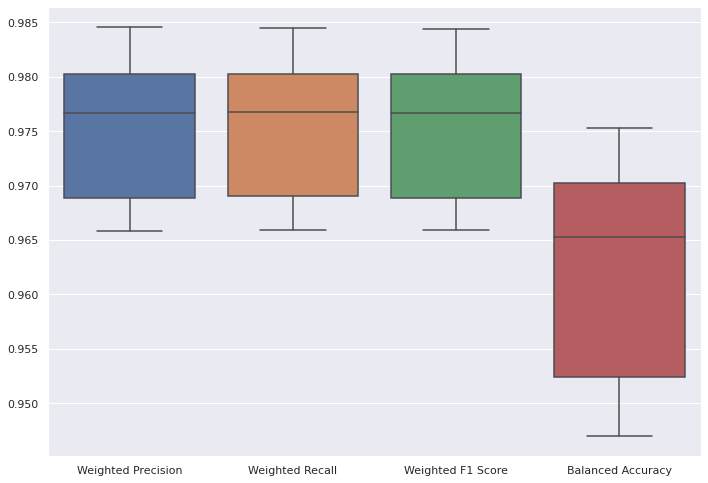

In [45]:
#"RUN 4"
#parameters (changed in each run)
alpha=1.0
fit_prior=True
class_prior=[0.2,0.8]
one_hot_encoded_wine_df = one_hot_encode(raw_df, target=target, features=model_features, n_buckets=27)

# training, testing validating the data
naive_bayes_k_fold(one_hot_encoded_wine_df, alpha, fit_prior, class_prior)
print_stats(run_num=4, model_case='bayes')

Unsurprisingly, the weighted precision, recall, and F1 score go up compared to runs 1-3, with a lower error bar roughly equal to the upper error bar on run 2 (which had the best "upper value" for each of these metrics).

Intuitively, there is a good case to be made that this is an example of overfitting Naive Bayes on the data. By splitting each feature into 27 sub-features, the algorithm is being trained on 27*4 = 108 predictors. Relative to the training and test data, that means that there are is 1 feature for every 6 samples the model is being trained on. This is also reflected in the error bars for balanced accuracy: whereas no previous run exceeded an error of 0.015, the error on the balanced accuracy for this run is almost doubled at ~0.025, suggesting that the training data has a greater impact on the model's performance compared to the previous runs

Repeating the experiment below with the maximum possible bucket size for some known poor predictors (alcohol, pH, and citric acid) and 19 buckets (the maximum possible bucket size for these features), there is a signficant reduction across all categories. Accuracy in particular is very poor, at around 60%, despite having 19 buckets per feature to build the model. This example makes it clear that the number of buckets used to encode the data is much less important than just choosing better features in the first place.

Printing summary statistics for  5  of bayes...




,Weighted Precision,Weighted Recall,Weighted F1 Score,Balanced Accuracy
0,0.755105,0.768161,0.722335,0.597674
1,0.770256,0.794436,0.757856,0.603077
2,0.784658,0.794436,0.757577,0.622394
3,0.756553,0.789474,0.748900,0.582254
4,0.764705,0.786378,0.744050,0.594573
5,0.757731,0.770898,0.724019,0.594958
6,0.758491,0.792570,0.751008,0.578499
7,0.765399,0.781734,0.734958,0.590818
8,0.771944,0.780186,0.737266,0.608537
9,0.788321,0.786378,0.742666,0.614916


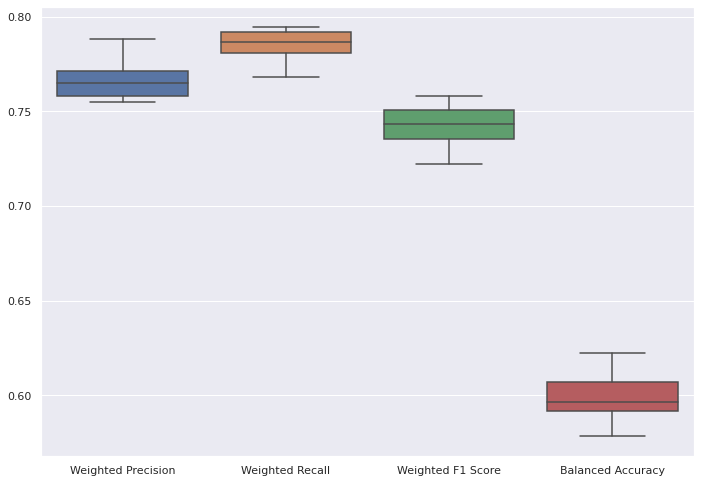

In [46]:
#"RUN 5"
#parameters (changed in each run)
alpha=1.0
fit_prior=True
class_prior=[0.2,0.8]
one_hot_encoded_wine_df = one_hot_encode(raw_df, target, features={'alcohol','pH','citric acid'}, n_buckets=19)

# training, testing validating the data
naive_bayes_k_fold(one_hot_encoded_wine_df, alpha, fit_prior, class_prior)
print_stats(run_num=5, model_case='bayes')

#References
-----
##Section 1
##Section 2
##Section 3
#####Consulted on domain knowledge comparing red and white wines:

https://advancedmixology.com/blogs/art-of-mixology/red-vs-white-wine

https://www.napacabs.com/blog/white-wine-vs-red-wine-whats-the-difference/

https://www.scielo.br/j/cta/a/HQsrPrPMNZYgRzSKtrjHyHh/?format=pdf&lang=en

https://mantech-inc.com/wp-content/uploads/2014/07/105-Chloride-in-Wine-by-Titration.pdf

#####MI scores
Code (modified): https://www.kaggle.com/code/ryanholbrook/mutual-information

Reference on analytical feature selection: https://scikit-learn.org/stable/modules/feature_selection.html

Reference on MI score: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif

##Section 4
##Section 5
Theory taken from:
https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=Cross%2Dvalidation%20is%20a%20resampling,is%20to%20be%20split%20into.

https://scikit-learn.org/stable/modules/cross_validation.html

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection
##Section 6, 7, 8
Consulted on performance measures (precision, recall, F-measure): https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

Consulted on performance measures (macro-avg, micro-avg): https://www.kaggle.com/general/185896
##Section 9
##Section 10

# References (kept from before refactor to make sure none are lost)

Data source: https://www.kaggle.com/datasets/rajyellow46/wine-quality

Feature utility metric reference: https://www.kaggle.com/code/ryanholbrook/mutual-information

Categorical variables: https://www.kaggle.com/code/alexisbcook/categorical-variables/tutorial

https://www.kaggle.com/code/ryanholbrook/mutual-information

(Reference on feature selection: https://scikit-learn.org/stable/modules/feature_selection.html)

https://guhanesvar.medium.com/feature-selection-based-on-mutual-information-gain-for-classification-and-regression-d0f86ea5262a

Kaggle feature engineering tutorials: https://www.kaggle.com/learn/feature-engineering

# DISCLOSURE

This is the third dataset I selected for this project. Since there may have been influence on this iteration by the work I did on my last two datasets, I have included references to the resources I used in the first iteration of this project under "Works Cited."

Iteration 1 is also available on Github: https://github.com/journalWheat/CSI4106Project1-JaredWagner

As well as iteration 2: 
https://github.com/journalWheat/CSI4106-Project1-JaredWagner-WaterPotability